In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import spearmanr,pearsonr

In [295]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [296]:
plt.style.use('fivethirtyeight')

In [297]:
pd.options.display.max_columns = 150

In [298]:
train = pd.read_csv('clean_train_set.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,dependency,techowaste,elecother,instlevel0,rent-missing
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,10,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4,0.0,0,0,0,0
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,12,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4,0.0,0,0,0,0
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,11,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4,0.0,0,0,0,0
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,9,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4,1.0,0,0,0,0
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,11,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4,1.0,0,0,0,0


In [299]:
group = train.groupby('Target',sort=True)['Target'].count()

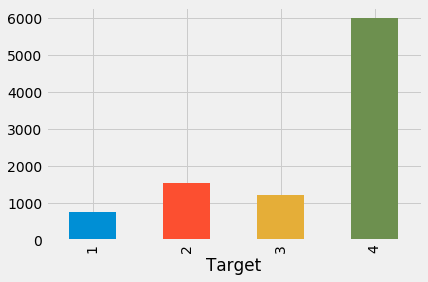

In [300]:
#lets see the number of samples present in the dataset for each poverty level
train.groupby('Target',sort=True)['Target'].count().plot(kind='bar')
plt.show()

#### we have an imbalanced class problem where we have a high number of non-vulnerable households.
#### we can apply suitable methods such as oversampling to help our model with predicting these levels correctly.
#### we should be taking this into consideration in the modelling phase.

In [396]:
#for plotting distributions with respect to each poverty level
def plot_distribution_cat(data,column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
    poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})
    for i,col in enumerate(column_list):
        ax = plt.subplot(4,2,i+1)
        for level,color in colors.items():
            sns.kdeplot(train.loc[train['Target'] == level, col],ax=ax,color=color,label=poverty_mapping[level])
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
    plt.subplots_adjust(top = 2)

def plot_categorical(column,desc,label,kind):
    grouped = train.groupby(['Target'])[column].value_counts(normalize=True)
    grouped = grouped.rename('count')
    grouped = grouped.reset_index(['Target',column])
    if kind == 'bar':
        sns.barplot(x=column, y="count", hue="Target", data=grouped,palette=OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}))
        if isinstance(label[0],str):
            rotation=60
        else:
            rotation=0
    elif kind == 'point':
        sns.pointplot(x=column, y="count", hue="Target", data=grouped,palette=OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}),dodge=0.18)
        rotation=0
    plt.xlabel(desc)
    plt.ylabel('normalized_count')
    locs,labels = plt.xticks()
    plt.xticks(locs,label,rotation=rotation)
    plt.legend(loc='best')
    plt.show()
    
def create_ordinal_columns(df,feat_dict):
    for col_name,col_list in feat_dict.items():
        df[col_name] = df[col_list].apply(lambda x:np.argmax(x),axis=1,raw=True)
        print('created ordinal column {}'.format(col_name))

def corr_heatmap(column_list,method='pearson'):
    plt.figure(figsize = (8, 10))
    corr = train[column_list].corr(method)
    sns.heatmap(corr,cmap='binary_r')
    plt.show()
#calculate spearman and pearson correlation of columns with the Target column    
def calc_sp_pr(columns):
    scorr = []
    S_p_value = []
    pcorr = []
    P_p_value = []
    for col in columns:
        scorr.append(spearmanr(train[col],train['Target']).correlation)
        pcorr.append(pearsonr(train[col],train['Target'])[0])
        S_p_value.append(spearmanr(train[col],train['Target']).pvalue)
        P_p_value.append(pearsonr(train[col],train['Target'])[1])
    return pd.DataFrame({'spearman_r':scorr,'S_p_value':S_p_value,'pearson_r':pcorr,'P_p_value':P_p_value},index=columns).sort_values('spearman_r',ascending=False)

def boxplot_distribution(column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
    poverty_mapping = ['extreme','moderate','vulnerable','non-vulnerable']
    for i,col in enumerate(column_list):
        ax = plt.subplot(4,2,i+1)
        sns.boxplot(x='Target',y=col,data=train,ax=ax,palette=colors)
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
        locs,labels = plt.xticks()
        plt.xticks(locs,poverty_mapping)
    plt.subplots_adjust(top = 2)
        

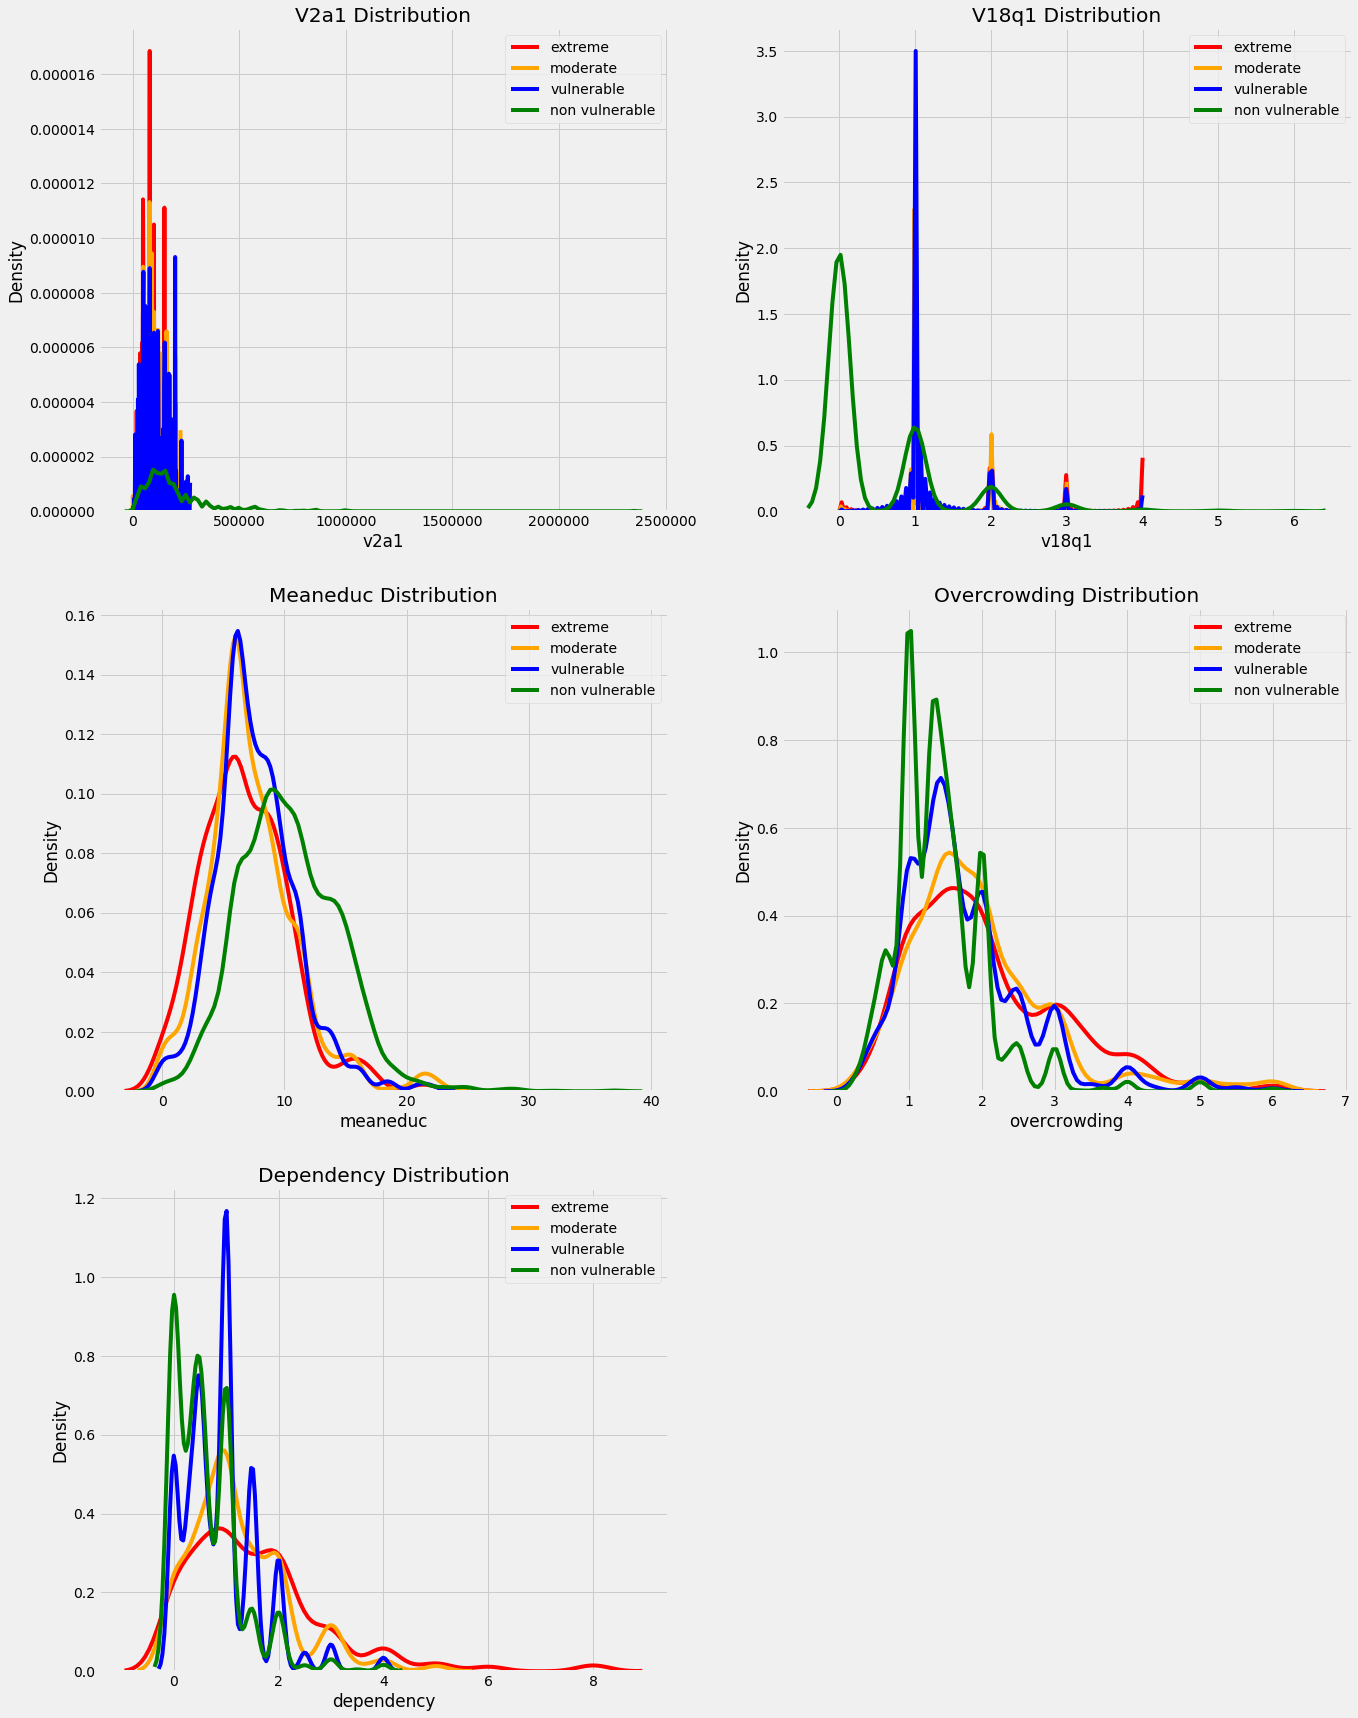

In [302]:
#let us check the distribution of our continuous value columns
float_columns = train.select_dtypes('float')
plot_distribution_cat(train,float_columns)

# a quick look at the figures allows to see if these columns have different distributions depending on the poverty level.

#### 1.we can see a clear difference in the v18q1 column,where vulnerable households usually own a single tablet,whereas non-vulnerable households have a range of values.We can also see a small spike for extreme households at 4,which is quite unexpected for the number of tablets owned.
#### 2.we can also see a difference in the overcrowding column where non-vulnerable households have spikes between 1 and 3 before its               distribution tapers off,whereas we see that much of the area of the distribution covers values from 1 to 4 before tapering off.
#### 3.we see that the non-vulnerable distribution in the meaneduc column is slightly shifted to the right than the other distributions,indicating a higher mean education for these households.

# Rooms

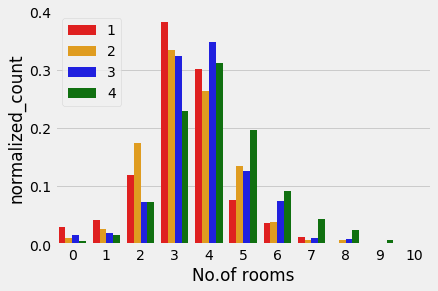

In [303]:
#let us check if there is a difference in the number of rooms in the households
plot_categorical('rooms','No.of rooms',kind='bar',label=[i for i in range(0,13)])

#### non-vulnerable households have a much larger range of rooms ranging from 0 to 11
#### the other households have 3-4 rooms and 5-6 in some cases

# r4t3, Total persons in the household, size of the household

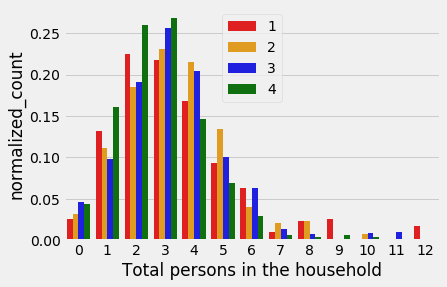

In [304]:
plot_categorical('hogar_total','Total persons in the household',label=[i for i in range(0,20)],kind='bar')

In [305]:
#let us check if there is a correlation between no.of rooms and total persons in the household
train[['rooms','r4t3']].corr()

,rooms,r4t3
rooms,1.000000,0.245784
r4t3,0.245784,1.000000


# No. of children,adults and elderly people

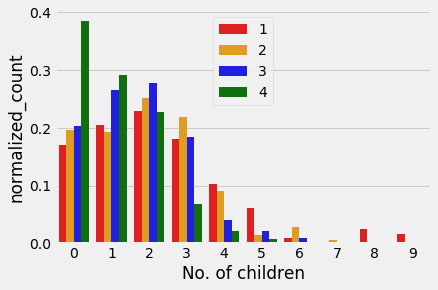

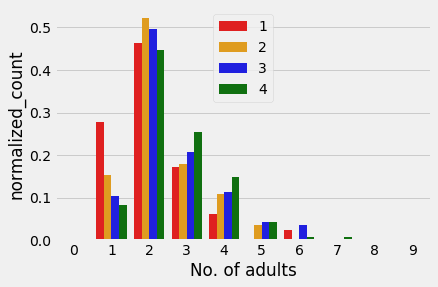

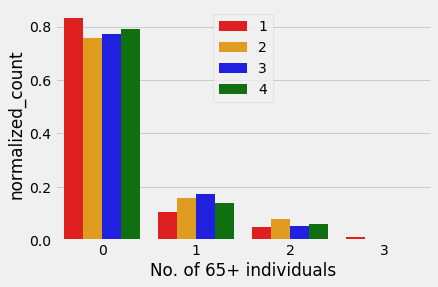

In [306]:
#let us check the no. of children,adults and elderly people for each poverty level.
plot_categorical('hogar_nin','No. of children',kind='bar',label=[i for i in range(0,15)])
plot_categorical('hogar_adul','No. of adults',kind='bar',label=[i for i in range(0,15)])
plot_categorical('hogar_mayor','No. of 65+ individuals',kind='bar',label=[i for i in range(0,15)])

#### There are more number of children in extreme and moderate poverty households compared to the other poverty levels,sometimes 8 or 9 in some cases.Vulnerable and non-vulnerable poverty level households have upto 3 children after which the counts taper off sharply from 4.

# Region

In [307]:
regions = [reg for reg in train.columns if reg.startswith('lugar')]
train['region'] = train[regions].apply(lambda x:np.argmax(x),axis=1,raw=True)
region_names=['Central','Chorotega','Pacafico central','Brunca','Huetar Atlantica','Huetar Norte']

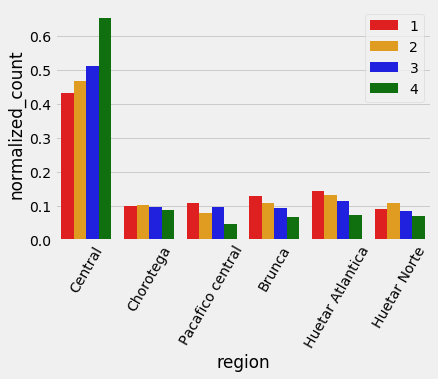

In [308]:
plot_categorical('region','region',region_names,kind='bar')

#### the poverty levels are more or less evenly distributed accross these regions.
#### There are a lot more samples from region 0 though.

In [309]:
train.drop('region',axis=1,inplace=True)

# Education

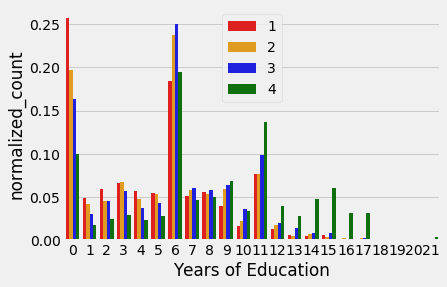

In [310]:
plot_categorical('escolari','Years of Education',label=[i for i in range(0,22)],kind='bar')

#### we observe three prominent spikes in the figure at year 0,6 and 11 for all the poverty levels.
####  we can also observe the fact that extreme poverty households have the highest count at year 0 followed by other poverty level households in descending order of the level.
#### only non vulnerable households appear to pursue higher education from year 12 onwards

# Amenities(Refrigerator,TV,bathroom,tablet,mobile phone,computer)

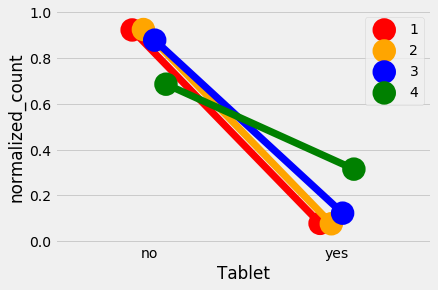

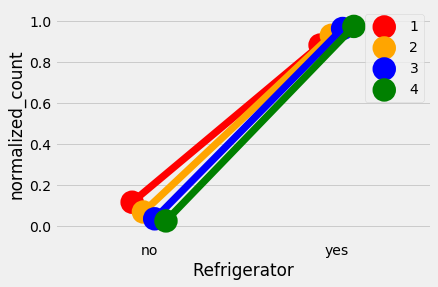

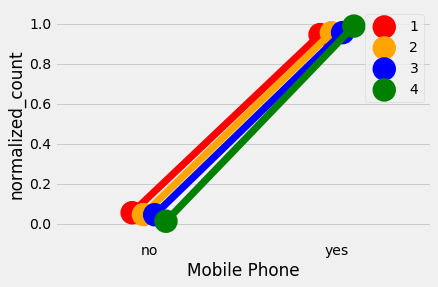

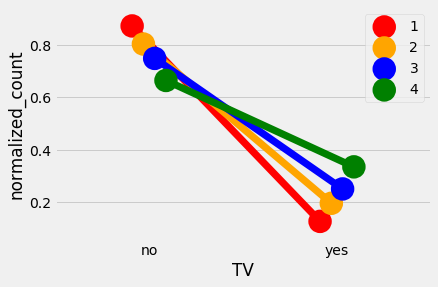

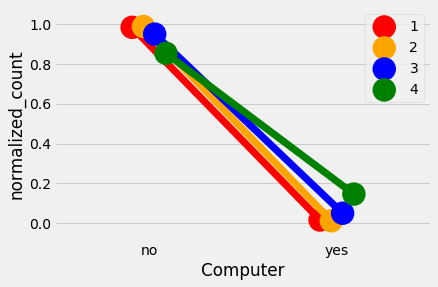

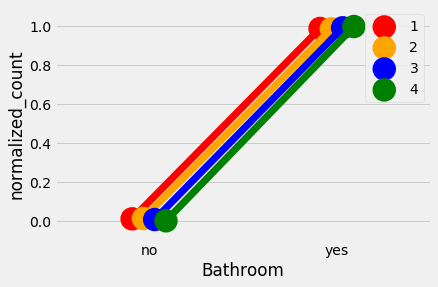

In [311]:
plot_categorical('v18q','Tablet',['no','yes'],kind='point')
plot_categorical('refrig','Refrigerator',['no','yes'],kind='point')
plot_categorical('mobilephone','Mobile Phone',['no','yes'],kind='point')
plot_categorical('television','TV',['no','yes'],kind='point')
plot_categorical('computer','Computer',['no','yes'],kind='point')
plot_categorical('v14a','Bathroom',['no','yes'],kind='point')

# Feature Construction
#### some columns have an inherent ordering between them,and therefore it would be useful if we incorporate this ordering or structure in our data
#### for e.g columns indicating wall quality have a natural ordering of bad < regular < good

In [312]:

ordinal_attributes = {'wall_attrib' :['paredother','pareddes','paredfibras','paredmad','paredzinc','paredzocalo','paredblolad','paredpreb'],
                       'floor_attrib':['pisonotiene','pisoother','pisonatur','pisomadera','pisocemento','pisomoscer'],
                       'roof_attrib' :['techootro','techowaste','techocane','techozinc','techoentrepiso'],
                       'water_attrib':['abastaguano','abastaguafuera','abastaguadentro'],
                       'electric_attrib' : ['noelec','elecother','coopele','public','planpri'],
                       'sanitary_attrib' : ['sanitario1','sanitario6','sanitario5','sanitario2','sanitario3'],
                       'energy_attrib' : ['energcocinar1','energcocinar4','energcocinar3','energcocinar2'],
                       'wall_qual' : ['epared1','epared2','epared3'],
                       'roof_qual' : ['etecho1','etecho2','etecho3'],
                       'floor_qual' : ['eviv1','eviv2','eviv3'],
                       'edu_level' : ['instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9'],
                       'ownership_status' : ['tipovivi5','tipovivi4','tipovivi3','tipovivi2','tipovivi1'],
                       'area':['area2','area1']
                  }

In [313]:
create_ordinal_columns(train,ordinal_attributes)

created ordinal column wall_attrib
created ordinal column floor_attrib
created ordinal column roof_attrib
created ordinal column water_attrib
created ordinal column electric_attrib
created ordinal column sanitary_attrib
created ordinal column energy_attrib
created ordinal column wall_qual
created ordinal column roof_qual
created ordinal column floor_qual
created ordinal column edu_level
created ordinal column ownership_status
created ordinal column area


In [314]:
# we need to drop the redundant attributes from the dataset
for col_list in ordinal_attributes.values():
    train.drop(col_list,axis=1,inplace=True)

In [315]:
#we need to drop one of the columns from [male,female]
#male column dropped
train.drop('male',axis=1,inplace=True)

In [316]:
train.shape

(9557, 85)

#### checking the correlation between household attributes

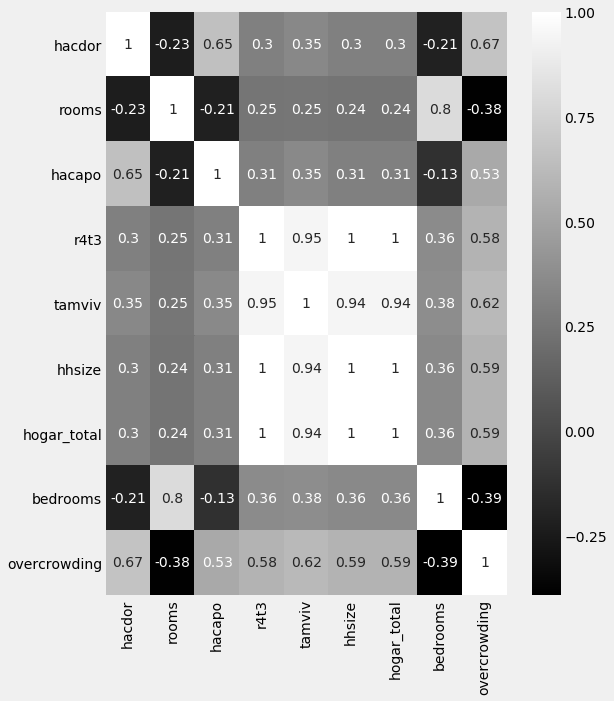

In [317]:
# household_level attributes
household_attributes = ['hacdor','rooms','hacapo','r4t3','tamviv','hhsize','hogar_total','bedrooms','overcrowding']
corr_heatmap(household_attributes)

#### hhsize,r4t3 and hogar_total are prefectly correlated

In [318]:
#we can drop hhsize and r4t3 and keep hogar_total in our dataset
train.drop(['hhsize','r4t3'],axis=1,inplace=True)

# let us also check the correlation of all the variables with the target

In [319]:
house_attributes = ['wall_attrib','floor_attrib','roof_attrib','water_attrib','electric_attrib','sanitary_attrib','energy_attrib','wall_qual','roof_qual','floor_qual',\
'edu_level','ownership_status']
results = calc_sp_pr(house_attributes)
results

,spearman_r,S_p_value,pearson_r,P_p_value
floor_qual,0.311631,2.849933e-214,0.305341,2.300743e-205
edu_level,0.310719,5.752589e-213,0.303256,1.849154e-202
wall_qual,0.307824,7.452545e-209,0.306255,1.207016e-206
floor_attrib,0.290977,7.773303e-186,0.255393,3.591930e-142
roof_qual,0.274310,1.456649e-164,0.271086,1.288205e-160
energy_attrib,0.182308,3.296043e-72,0.196094,1.820360e-83
wall_attrib,0.086473,2.489434e-17,0.159039,3.575496e-55
water_attrib,0.075060,2.022431e-13,0.081709,1.241835e-15
roof_attrib,0.060736,2.811327e-09,0.054658,8.959911e-08
ownership_status,0.038537,1.643553e-04,0.085542,5.436579e-17


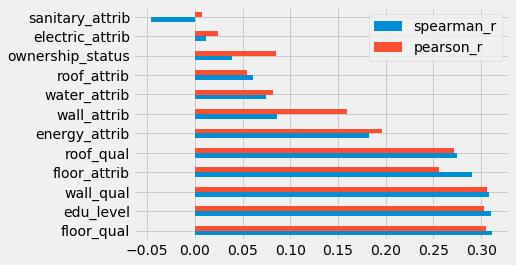

In [320]:
results[['spearman_r','pearson_r']].plot.barh()

#### floor,education level,wall,roof and floor quality have a slightly positive correlation with the poverty level
#### pearson and spearman correlation are in agreement for these attributes
#### these correlations have significant p-values as well.!!

In [321]:
# let us check the household attributes as well.
household_attributes = ['hacdor','rooms','hacapo','tamviv','hogar_total','bedrooms','overcrowding']
results = calc_sp_pr(household_attributes)
results

,spearman_r,S_p_value,pearson_r,P_p_value
rooms,0.233442,1.891549e-118,0.229089,4.988321e-114
bedrooms,0.173032,4.005544e-65,0.169381,1.923104e-62
hacapo,-0.134143,1.277670e-39,-0.137874,8.900343e-42
hogar_total,-0.149567,6.214835e-49,-0.145183,3.519778e-46
tamviv,-0.157883,2.171699e-54,-0.156352,2.313809e-53
hacdor,-0.181466,1.503663e-71,-0.192052,4.487093e-80
overcrowding,-0.280926,7.836512e-173,-0.289967,1.665280e-184


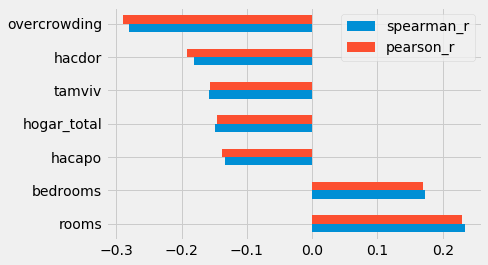

In [322]:
results[['spearman_r','pearson_r']].plot.barh()

#### overcrowding,hacdor,tamviv,hogar_total,hacapo have a negative correlation with poverty level.
#### This is understandable as these columns represent overcrowding,household size,persons living in each household etc.
#### We can see that as the poverty levels begin to decrease from non-vulnerable to extreme,these features begin to increase.
#### eg.extreme poverty levels tend to have more overcrowding whereas non-vulnerable households tend to have less overcrowding

In [323]:
amenities = ['v18q','refrig','mobilephone','television','computer','v14a']
results = calc_sp_pr(amenities)
results

,spearman_r,S_p_value,pearson_r,P_p_value
v18q,0.253694,3.007216e-140,0.239830,4.166716e-125
computer,0.192934,8.282842e-81,0.184136,1.189107e-73
television,0.155466,9.004274e-53,0.157077,7.567464e-54
refrig,0.119870,6.320563e-32,0.130326,1.780813e-37
mobilephone,0.109007,1.171679e-26,0.103688,2.912508e-24
v14a,0.065689,1.294536e-10,0.063321,5.804348e-10


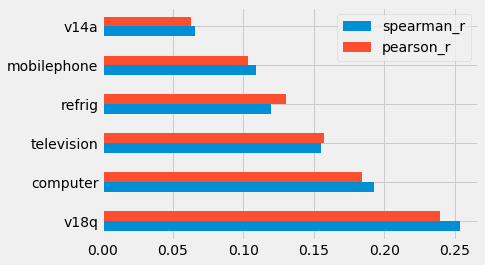

In [324]:
results[['spearman_r','pearson_r']].plot.barh()

#### amenities like refrigerator,television,mobile phone etc have a positive correlation with the poverty level.
#### as the poverty level increases from extreme to non-vulnerable,we tend to see an increase in the households/individuals holding these amenities
#### the correlations are somewhat weak ranging from 0.06-0.23

## feature engineering

In [325]:
#![alt text](imagename.png "Title")--for pasting images

In [326]:
#diff between persons living and size of the household
#a positive score for having amenities like refrigerator,TV etc
#a pos score for living in an urban area
#score for good house condition
#households with female heads,more number of young children and elderly,living in rural areas are indicators of poverty
#school age children not attending school
# standard of living feature to assess if households have amenities like refrigerator,TV and other assets etc
#mean age of head of household
#mean edu of household head
#mean of no. of children age 12 and under,individuals age 65+ and over,mean of children under 18

In [327]:
#aggregate features such as age,escolari
#head without spouse
#phones,tablets per household

![alt text](poverty_rate.png "Poverty rate by region")

![alt text](characteristics.png "characteristics of households at different poverty levels")

In [328]:
#persons per room
train['person/room'] = train['rooms'] / train['hogar_total']
#proportion of males
train['prop_male'] = train['r4h3'] / train['hogar_total']
#proportion of females
train['prop_female'] = train['r4m3'] / train['hogar_total']
#rent per person
train['rent/person'] = train['v2a1'] / train['hogar_total']
#rent per room
train['rent/room'] = train['v2a1'] / train['rooms']
#single,divorced,widowed,separated
train['without_spouse'] = 0
train['without_spouse'][(train.estadocivil4 == 1) | (train.estadocivil5 == 1) | (train.estadocivil6 == 1) | (train.estadocivil7 == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## if household head is female as a feature

In [329]:
#if household head is female as a feature
train['female_head'] = 0

In [330]:
train['female_head'][(train.parentesco1 == 1) & (train.female == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## education of head of household

In [331]:
###would only be using heads of household for training

## proportion of children under 12

In [332]:
## proportion of children under 12
train['prop_under_12'] = train['r4t1']/train['hogar_total']

## proportion of adults

In [333]:
#proportion of adults
train['prop_adults'] = train['hogar_adul']/train['hogar_total']

## proportion of elderly

In [334]:
#proportion of elderly
train['prop_elderly'] = train['hogar_mayor']/train['hogar_total']

## education of children 0-12

In [335]:
#education of children 0-12
idx_edu_chld = train[train.age <= 12].groupby('idhogar')['escolari'].mean()
idx_edu_chld = idx_edu_chld.reset_index()

In [336]:
idx_edu_chld.rename(columns={"escolari": "mean_edu_child"},inplace=True)

In [337]:
train = train.merge(idx_edu_chld,on='idhogar',how='left')

In [338]:
#there would be some rows where mean_edu_child would be Nan as there would be some households that do not have children aged 0-12
#because we are doing a left join on merge,some rows would be Nan as the idhogar values on our training set would not be in idx_edu_chld 
#as the households' do not have children aged 0-12
train['mean_edu_child'].fillna(0,inplace=True)

## education of children 12-18

In [339]:
#education of children 12-18
idx_edu_teen = train[(train.age >= 12) & ( train.age < 19)].groupby('idhogar')['escolari'].mean()
idx_edu_teen = idx_edu_teen.reset_index()

In [340]:
idx_edu_teen.rename(columns={"escolari": "mean_edu_teen"},inplace=True)

In [341]:
train = train.merge(idx_edu_teen,on='idhogar',how='left')

In [342]:
#there would be some rows where mean_edu_child would be Nan as there would be some households that do not have children aged 0-12
#because we are doing a left join on merge,some rows would be Nan as the idhogar values on our training set would not be in idx_edu_chld 
#as the households' do not have children aged 0-12
train['mean_edu_teen'].fillna(0,inplace=True)

## standard of living score
1/4(1/4(electricity) + 1/2(water) + 1/3(energy) +  1/5(sanitation) + 1/6(refrig + TV + mobile + tablet + computer + bathroom))

In [343]:
#standard of living score
#it would consider electricity,water,energy used for cooking,sanitation,amenities like refrigerator,TV,mobile phone etc.
# it would have a low score 0 and a max score of 1
#since we have ordered these features,it would be easy for us to normalize and add them for a final score.

In [344]:
train['standard_of_living'] = 1/5 * (1/4 * train['electric_attrib'] + 1/2 * train['water_attrib'] + 1/3 * train['energy_attrib'] + 1/4 * train['sanitary_attrib']\
+ 1/5 * (train['refrig'] + train['television'] + train['v18q'] + train['mobilephone'] + train['computer']))

## house_quality
#### outside_wall + roof + floor + cieling
1/4(1/2(wall qual) x 1/6(wall_attrib) + 1/2(floor qual) x 1/5(floor_attrib) + 1/2(roof qual) x 1/4(roof_attrib) + ceiling)

In [345]:
train['house_quality'] = 1/4 * ((1/2 * train['wall_qual']) * (1/6 * train['wall_attrib'])+ (1/2 * train['floor_qual']) * (1/6 * train['floor_attrib']) + (1/2 * train['roof_qual']) * (1/6 * train['roof_attrib']) + train['cielorazo'])

## variety of gadgets

In [349]:
## variety of gadgets
train['gadgets'] = 1/5 * (train['refrig'] + train['television'] + train['v18q'] + train['mobilephone'] + train['computer'])
## number of gadgets
train['n_gadgets'] = train['qmobilephone'] + train['v18q1']
##gadgets per person
train['gadget/person'] = train['n_gadgets'] / train['hogar_total']

### safe waste disposal
#### if disposal by tanker truck or burying 

In [346]:
train['safe_waste_disposal'] = 0
train['safe_waste_disposal'][(train.elimbasu1 == 1) | (train.elimbasu2 == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [347]:
#aggregating age,escolari features
def agg_features(df,col_list):
    # Define custom function
    range_ = lambda x: x.max() - x.min()
    range_.__name__ = 'range_'
    
    col_list.append('idhogar')
    
    ind = df[col_list]
    
    # Group and aggregate
    ind_agg = ind.groupby('idhogar').agg(['min', 'max', 'sum', 'mean', 'std', range_])
    ind_agg.head()
    
    new_col = []
    for c in ind_agg.columns.levels[0]:
        for stat in ind_agg.columns.levels[1]:
            new_col.append(f'{c}-{stat}')

    ind_agg.columns = new_col
    
    # Create correlation matrix
    corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
    
    print('no. of features to drop having correlation > 0.95:',len(to_drop))
    
    if len(to_drop) > 0:
        ind_agg = ind_agg.drop(columns = to_drop)
        
    print('train features shape before aggregation: ', df.shape)

    ind_agg = ind_agg.fillna(0)
    # Merge on the household id
    final = df.merge(ind_agg, on = 'idhogar', how = 'left')

    print('train features shape after aggregation: ', final.shape)
    
    return final
    
    
    

In [350]:
agg_col_list = ['age','escolari','v2a1','house_quality','standard_of_living','dependency','gadgets','gadget/person','n_gadgets']
train = agg_features(train,agg_col_list)

no. of features to drop having correlation > 0.95: 15
train features shape before aggregation:  (9557, 101)
train features shape after aggregation:  (9557, 140)


In [375]:
#we would be dropping the leftover categorical variables such as elimbasu[*] columns,estadiocivil[*] and parentesco[2,9] columns
waste_categorical = ['elimbasu{}'.format(i) for i in range(1,7)]
train.drop(waste_categorical,axis=1,inplace=True)
relationship_categorical = ['estadocivil{}'.format(i) for i in range(1,8)]
train.drop(relationship_categorical,axis=1,inplace=True)
member_categorical = ['parentesco{}'.format(i) for i in range(2,13)]
train.drop(member_categorical,axis=1,inplace=True)

KeyError: "['elimbasu1' 'elimbasu2' 'elimbasu3' 'elimbasu4' 'elimbasu5' 'elimbasu6'] not found in axis"

In [353]:
#No. of columns after feature engineering
train.shape
train.index = train.Id
train.drop('Id',axis=1,inplace=True)

## let us examine the distribution and relationship with the target variable

In [169]:
cont_variables = ['prop_adults','prop_under_12','prop_elderly','mean_edu_child','mean_edu_teen','standard_of_living','house_quality']

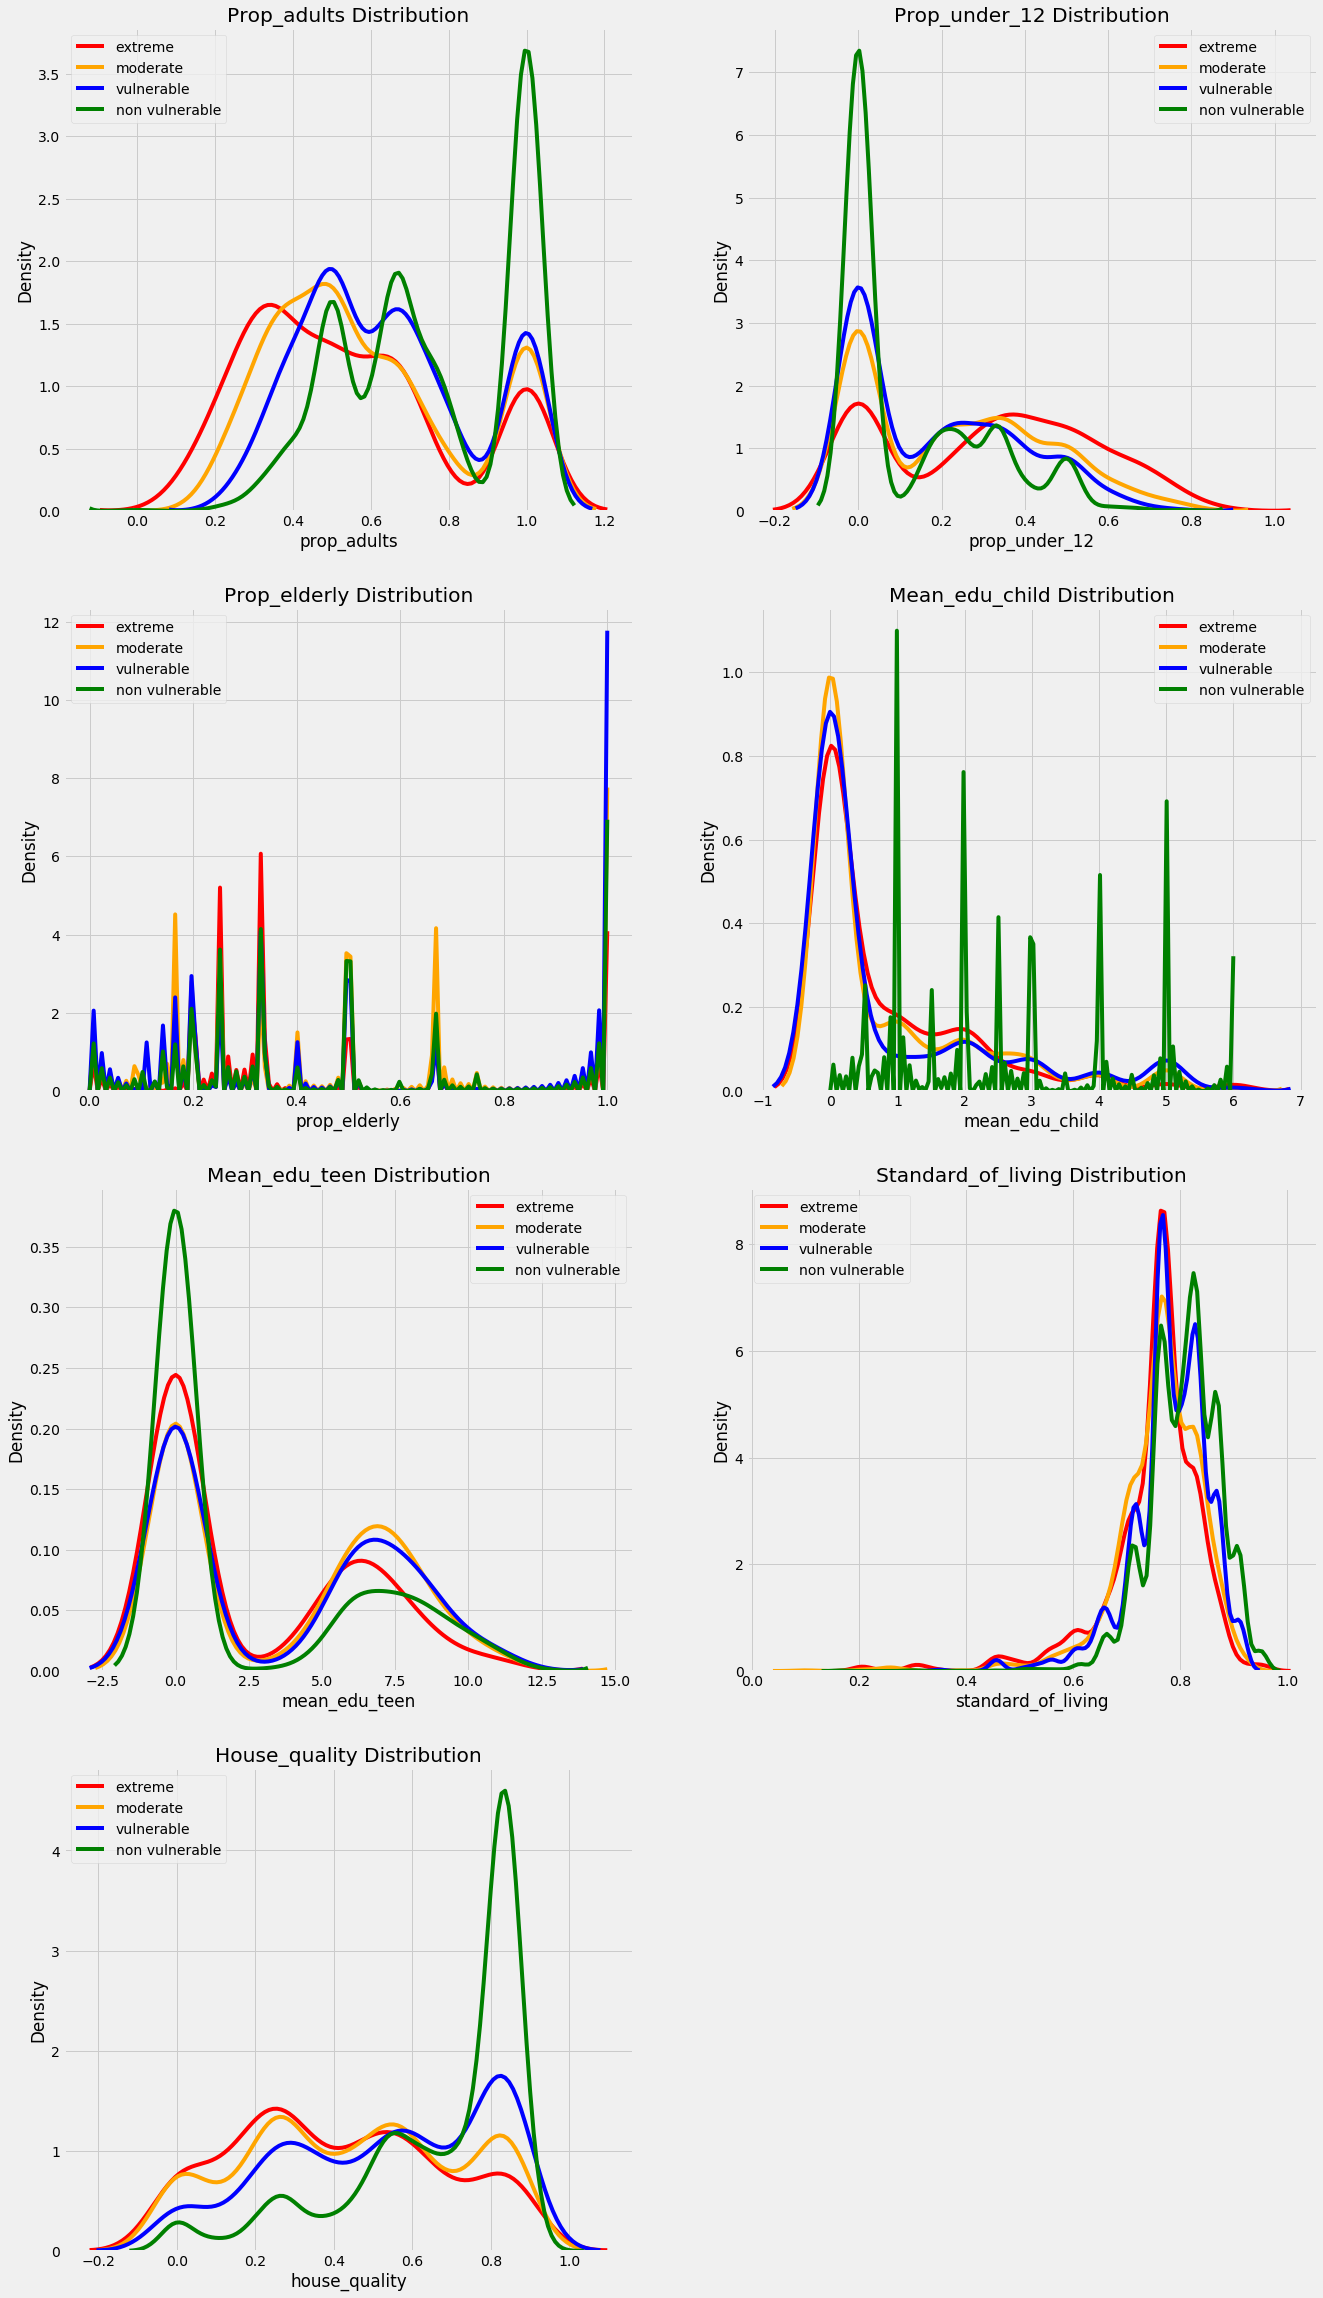

In [170]:
plot_distribution_cat(train,cont_variables)

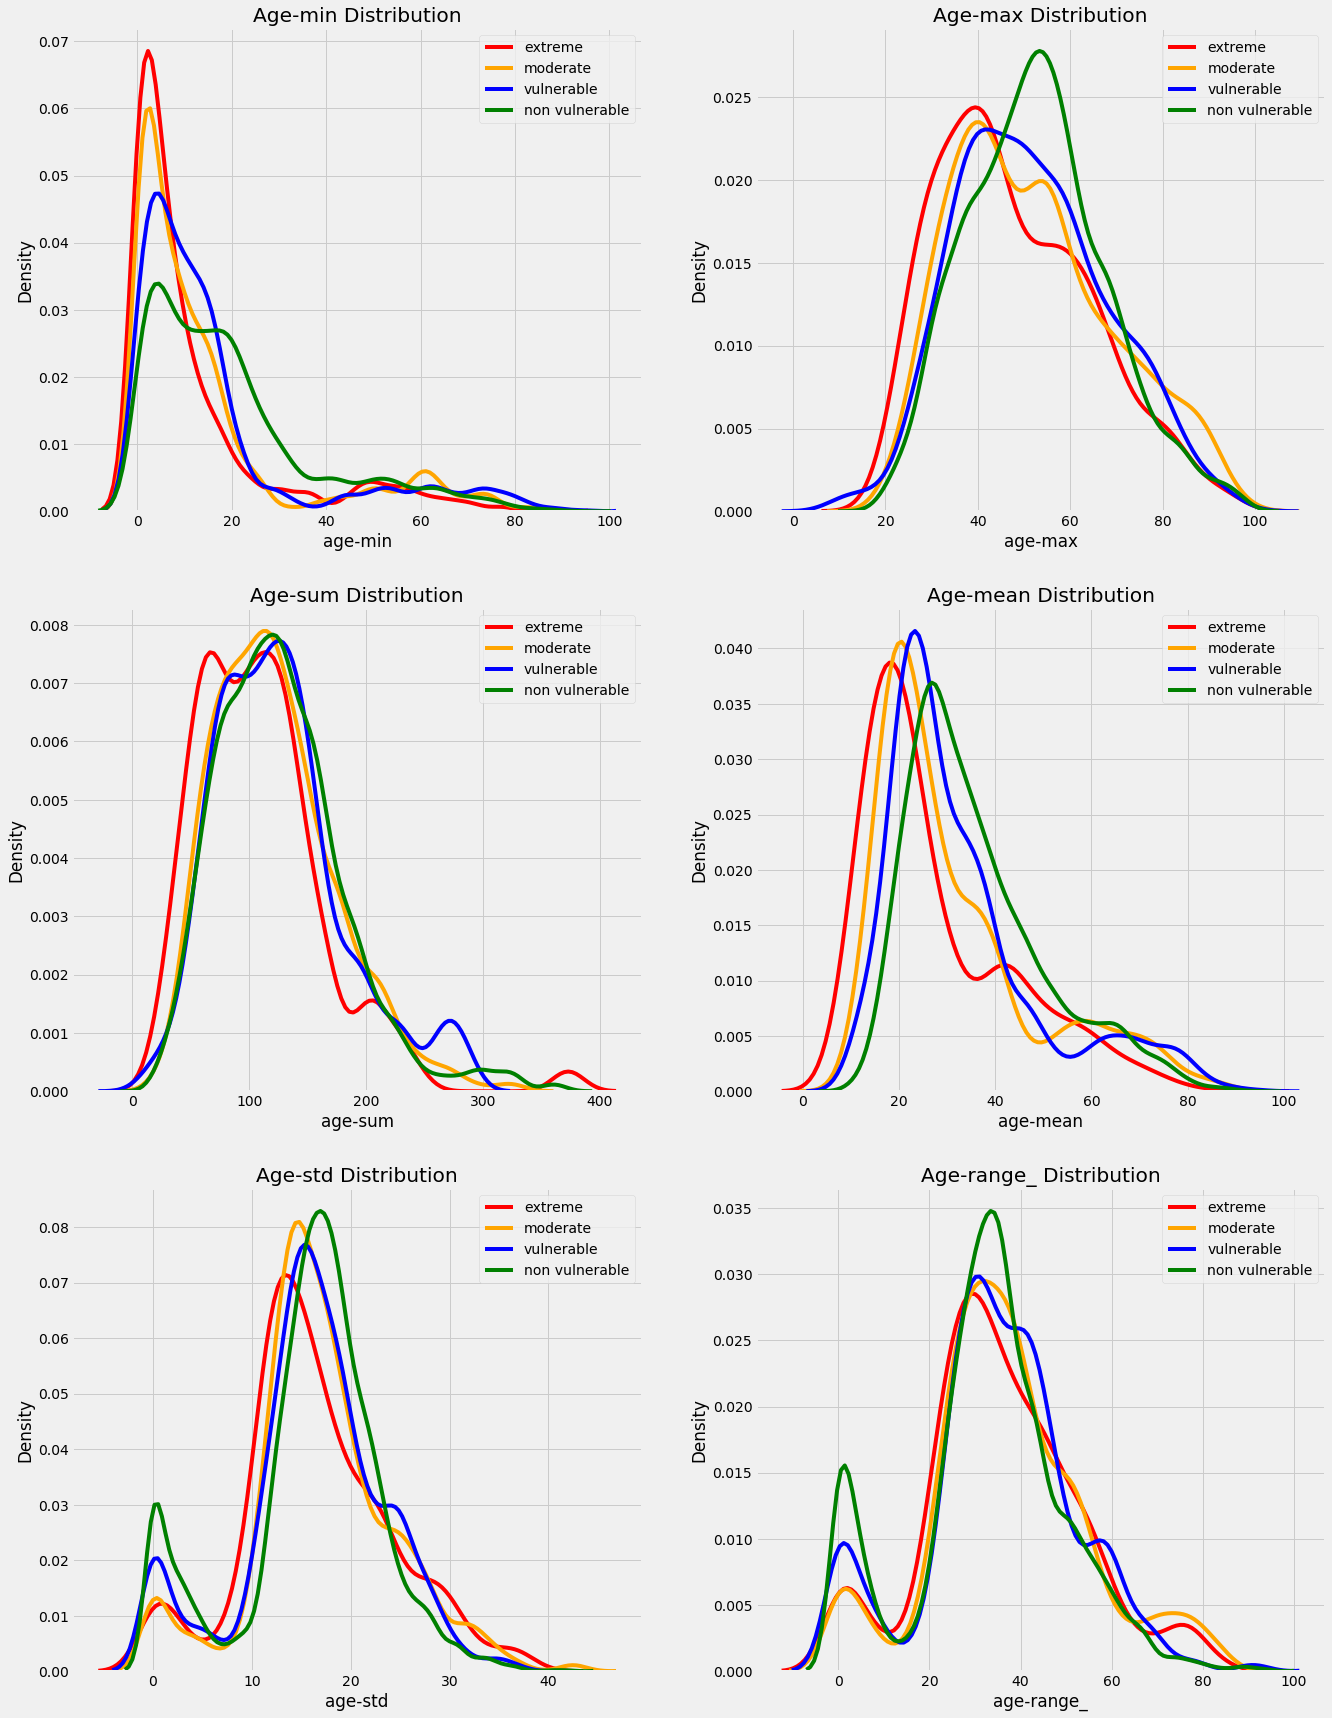

In [126]:
age_agg_features = ['age-min','age-max','age-sum','age-mean','age-std','age-range_']
plot_distribution_cat(train,age_agg_features)

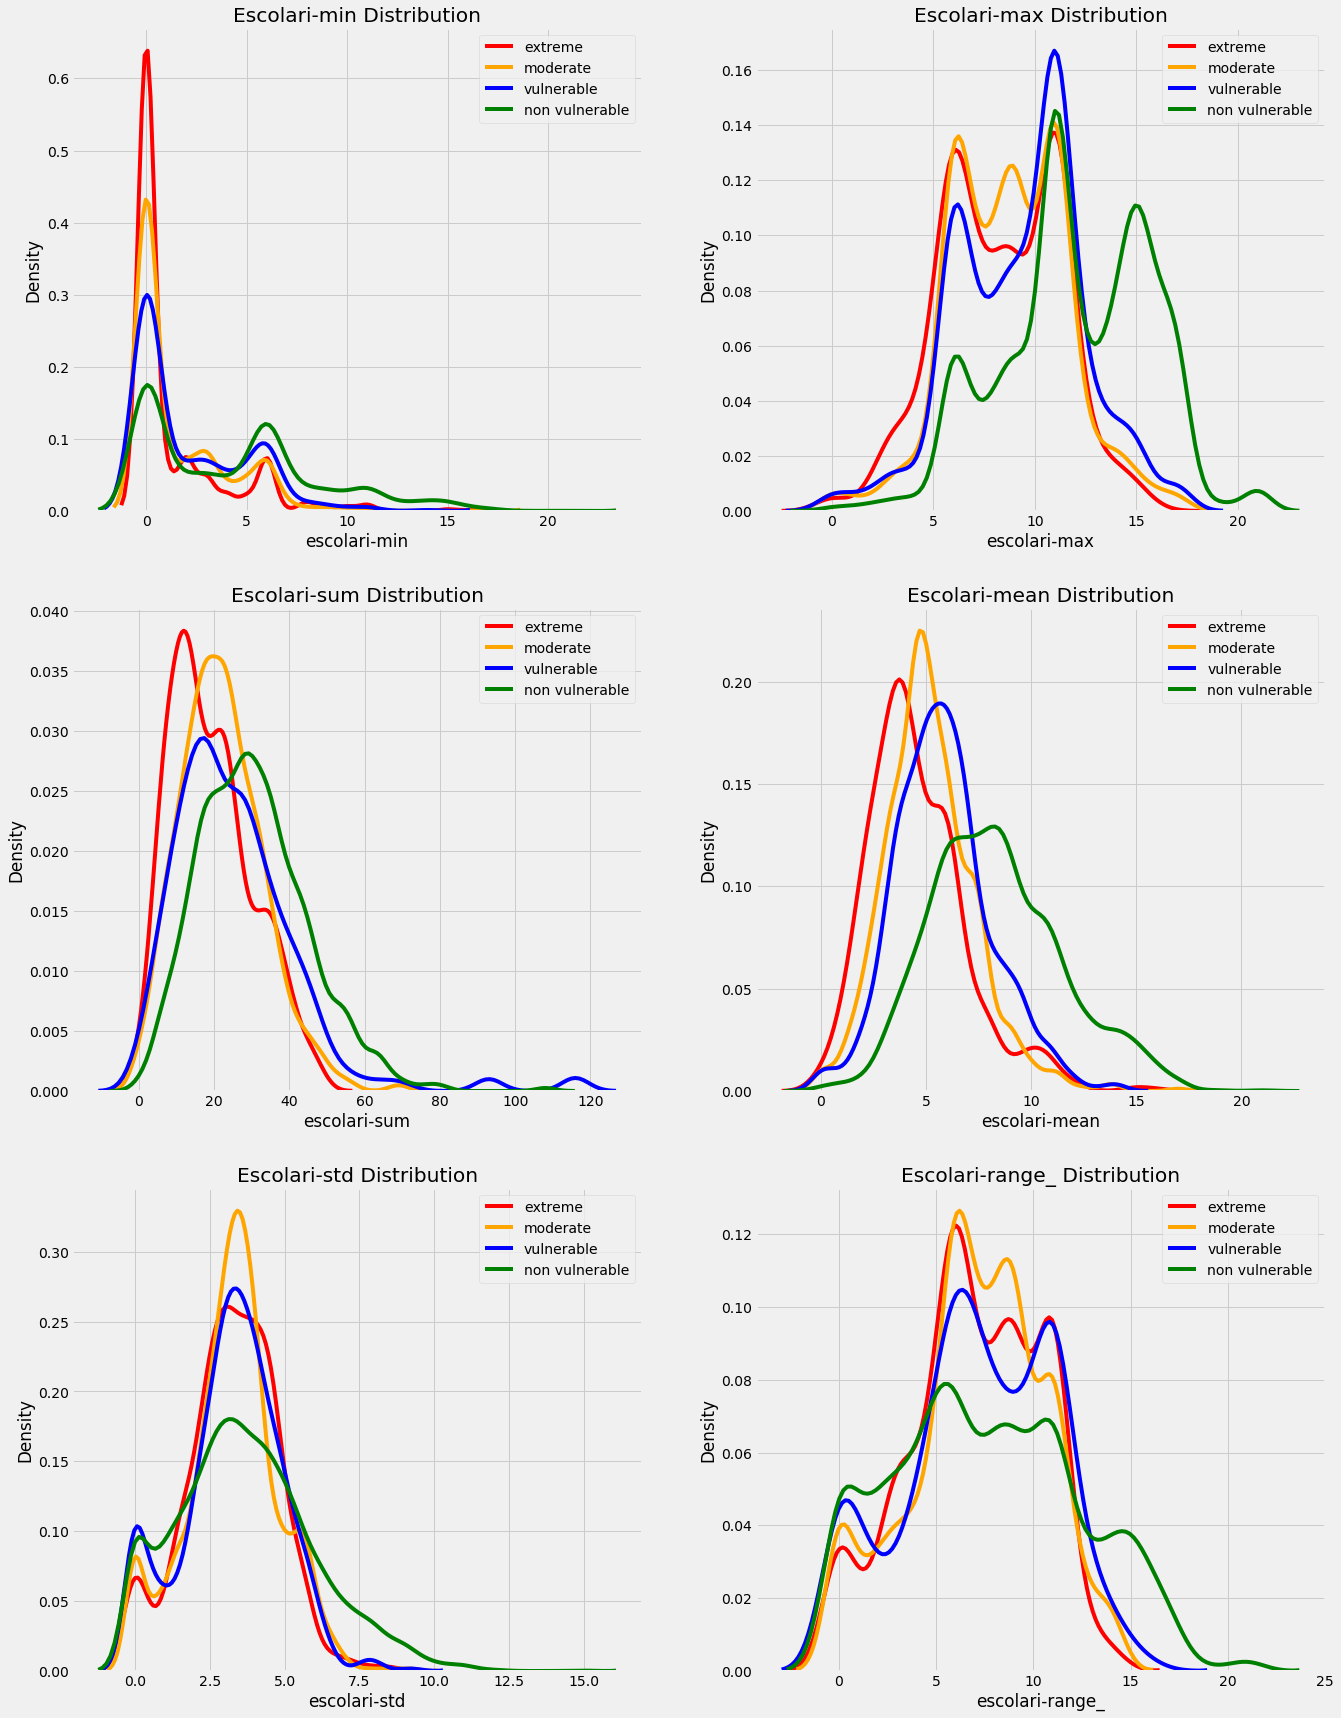

In [127]:
edu_agg_features = ['escolari-min','escolari-max','escolari-sum','escolari-mean','escolari-std','escolari-range_']
plot_distribution_cat(train,edu_agg_features)

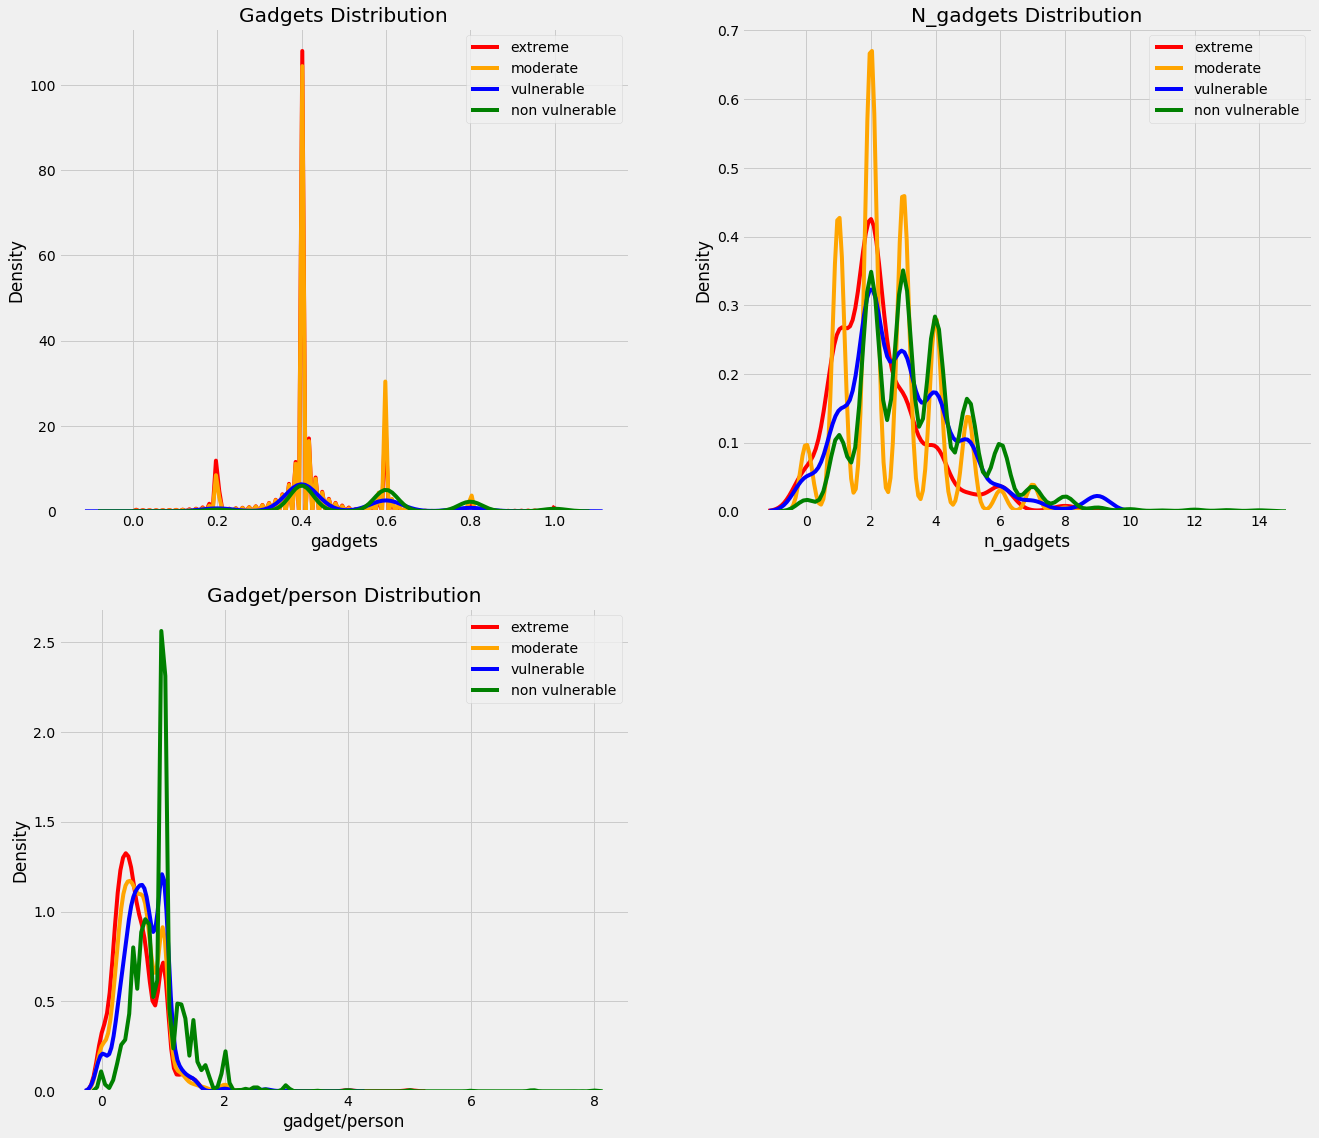

In [386]:
gadget_feats = ['gadgets','n_gadgets','gadget/person']
plot_distribution_cat(train,gadget_feats)

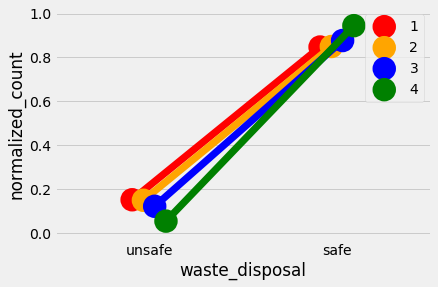

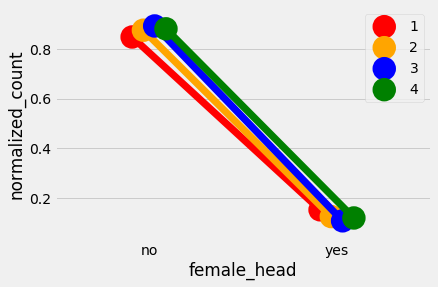

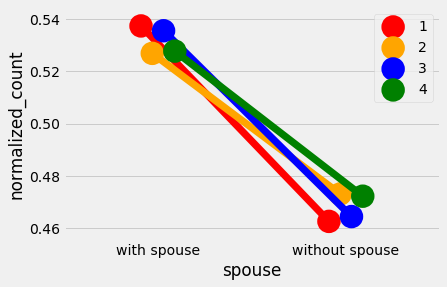

In [393]:
plot_categorical('safe_waste_disposal','waste_disposal',['unsafe','safe'],kind='point')
plot_categorical('female_head','female_head',['no','yes'],kind='point')
plot_categorical('without_spouse','spouse',['with spouse','without spouse'],kind='point')

#### let's check the correlation of the engineered features with the Target variable

In [184]:
new_features = ['age_of_head','female_head','edu_head','prop_under_12','prop_adults','prop_elderly','mean_edu_child','mean_edu_teen','standard_of_living','house_quality','safe_waste_disposal']
results = calc_sp_pr(new_features)
results

,spearman_r,S_p_value,pearson_r,P_p_value
house_quality,0.371821,0.000000e+00,0.376941,2.931786e-320
edu_head,0.343274,2.072640e-262,0.329019,5.591787e-240
prop_adults,0.324818,1.355864e-233,0.322644,2.492253e-230
standard_of_living,0.268493,1.965304e-157,0.278821,4.009249e-170
safe_waste_disposal,0.149225,1.061062e-48,0.143245,5.630112e-45
age_of_head,0.083386,3.248476e-16,0.074152,3.957894e-13
prop_elderly,-0.007357,4.721243e-01,0.003622,7.233274e-01
female_head,-0.015295,1.349367e-01,-0.020734,4.270076e-02
mean_edu_teen,-0.111717,6.453347e-28,-0.089600,1.717236e-18
mean_edu_child,-0.174565,3.012739e-66,-0.080717,2.755919e-15


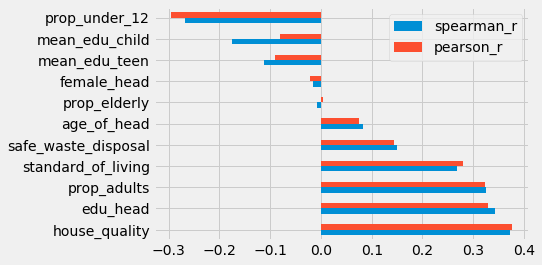

In [186]:
results[['spearman_r','pearson_r']].plot.barh()

In [389]:
engg_features = ['gadgets','n_gadgets','gadget/person','person/room','rent/person','rent/room','prop_male','prop_female']
results = calc_sp_pr(engg_features)
results

,spearman_r,S_p_value,pearson_r,P_p_value
gadget/person,0.408438,0.000000e+00,0.323864,3.130691e-232
gadgets,0.320658,1.925133e-227,0.308716,4.067000e-210
person/room,0.276596,2.150495e-167,0.190999,3.331368e-79
n_gadgets,0.270142,1.801785e-159,0.251793,4.078795e-138
rent/person,0.144007,1.865354e-45,0.155741,5.909604e-53
rent/room,0.135323,2.695960e-40,0.162499,1.496818e-57
prop_male,0.080523,3.179393e-15,0.083564,2.781986e-16
prop_female,-0.078562,1.458865e-14,-0.080687,2.793925e-15


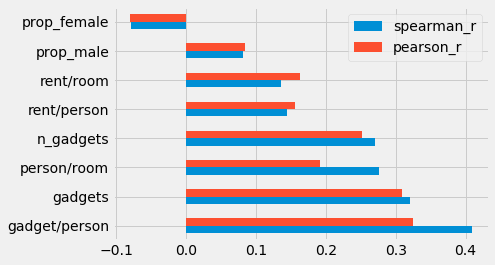

In [390]:
results[['spearman_r','pearson_r']].plot.barh()

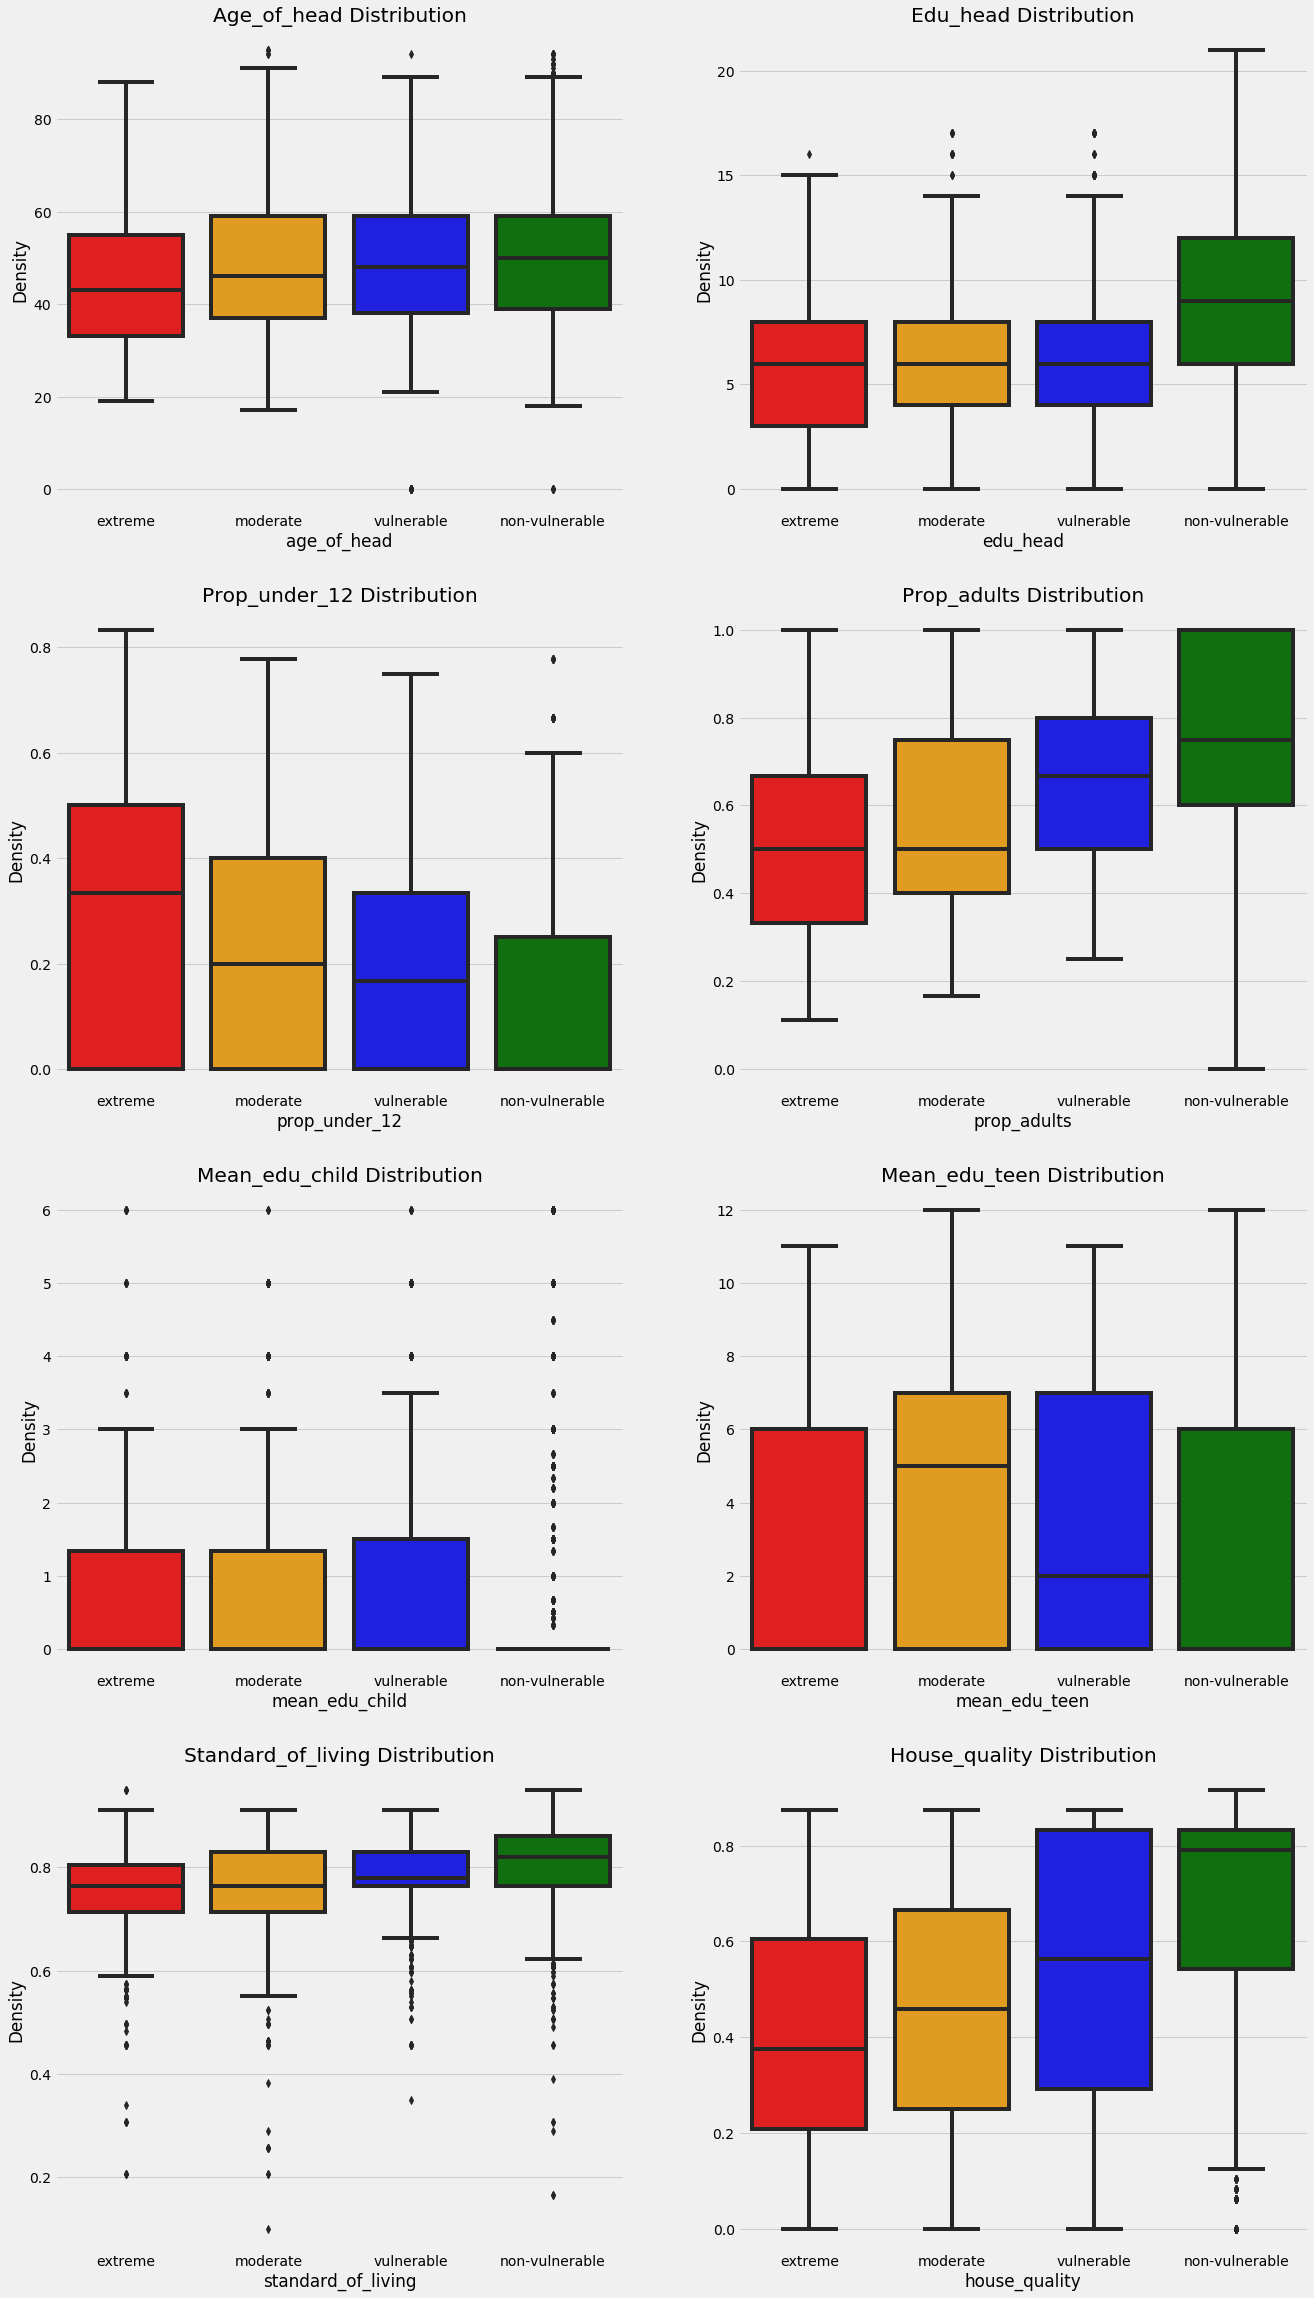

In [207]:
col_list = ['age_of_head','edu_head','prop_under_12','prop_adults','mean_edu_child','mean_edu_teen','standard_of_living','house_quality']
boxplot_distribution(col_list)

In [354]:
train.to_csv('training_set.csv')

## we need to prepare our testing set as well having the same features and ordinal columns as our training set

In [355]:
test = pd.read_csv('clean_test_set.csv')
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,dependency,techowaste,elecother,instlevel0,rent-missing
0,ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0.5,0,0,0,0
1,ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,16,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0.5,0,0,0,0
2,ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,17,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0.5,0,0,0,0
3,ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,16,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,16.000000,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,0.0,0,0,0,0
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,11,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,9.157474,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,0.0,0,0,0,0


In [356]:
#we need to drop one of the columns from [male,female]
#male column dropped
test.drop('male',axis=1,inplace=True)

In [357]:
#we can drop hhsize and r4t3 and keep hogar_total in our dataset
test.drop(['hhsize','r4t3'],axis=1,inplace=True)

In [358]:
ordinal_attributes = {'wall_attrib' :['paredother','pareddes','paredfibras','paredmad','paredzinc','paredzocalo','paredblolad','paredpreb'],
                       'floor_attrib':['pisonotiene','pisoother','pisonatur','pisomadera','pisocemento','pisomoscer'],
                       'roof_attrib' :['techootro','techowaste','techocane','techozinc','techoentrepiso'],
                       'water_attrib':['abastaguano','abastaguafuera','abastaguadentro'],
                       'electric_attrib' : ['noelec','elecother','coopele','public','planpri'],
                       'sanitary_attrib' : ['sanitario1','sanitario6','sanitario5','sanitario2','sanitario3'],
                       'energy_attrib' : ['energcocinar1','energcocinar4','energcocinar3','energcocinar2'],
                       'wall_qual' : ['epared1','epared2','epared3'],
                       'roof_qual' : ['etecho1','etecho2','etecho3'],
                       'floor_qual' : ['eviv1','eviv2','eviv3'],
                       'edu_level' : ['instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9'],
                       'ownership_status' : ['tipovivi5','tipovivi4','tipovivi3','tipovivi2','tipovivi1'],
                       'area':['area2','area1']
                  }

In [359]:
create_ordinal_columns(test,ordinal_attributes)

created ordinal column wall_attrib
created ordinal column floor_attrib
created ordinal column roof_attrib
created ordinal column water_attrib
created ordinal column electric_attrib
created ordinal column sanitary_attrib
created ordinal column energy_attrib
created ordinal column wall_qual
created ordinal column roof_qual
created ordinal column floor_qual
created ordinal column edu_level
created ordinal column ownership_status
created ordinal column area


In [360]:
for col_list in ordinal_attributes.values():
    test.drop(col_list,axis=1,inplace=True)

## mirroring the engineered features in the test set

In [361]:
#persons per room
test['person/room'] = test['rooms'] / test['hogar_total']
#proportion of males
test['prop_male'] = test['r4h3'] / test['hogar_total']
#proportion of females
test['prop_female'] = test['r4m3'] / test['hogar_total']
#rent per person
test['rent/person'] = test['v2a1'] / test['hogar_total']
#rent per room
test['rent/room'] = test['v2a1'] / test['rooms']
#single,divorced,widowed,separated
test['without_spouse'] = 0
test['without_spouse'][(test.estadocivil4 == 1) | (test.estadocivil5 == 1) | (test.estadocivil6 == 1) | (test.estadocivil7 == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [362]:
#if household head is female
test['female_head'] = 0
test['female_head'][(test.parentesco1 == 1) & (test.female == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [363]:
## proportion of children under 12
test['prop_under_12'] = test['r4t1']/test['hogar_total']

In [364]:
#proportion of adults
test['prop_adults'] = test['hogar_adul']/test['hogar_total']

In [365]:
#proportion of elderly
test['prop_elderly'] = test['hogar_mayor']/test['hogar_total']

In [366]:
#education of children 0-12
idx_edu_chld = test[test.age <= 12].groupby('idhogar')['escolari'].mean()
idx_edu_chld = idx_edu_chld.reset_index()
idx_edu_chld.rename(columns={"escolari": "mean_edu_child"},inplace=True)
test = test.merge(idx_edu_chld,on='idhogar',how='left')
test['mean_edu_child'].fillna(0,inplace=True)

In [367]:
#education of children 12-18
idx_edu_teen = test[(test.age >= 12) & (test.age <= 18)].groupby('idhogar')['escolari'].mean()
idx_edu_teen = idx_edu_teen.reset_index()
idx_edu_teen.rename(columns={"escolari": "mean_edu_teen"},inplace=True)
test = test.merge(idx_edu_teen,on='idhogar',how='left')
test['mean_edu_teen'].fillna(0,inplace=True)

In [369]:
#standard of living score
test['standard_of_living'] = 1/5 * (1/4 * test['electric_attrib'] + 1/2 * test['water_attrib'] + 1/3 * test['energy_attrib'] + 1/4 * test['sanitary_attrib']\
+ 1/5 * (test['refrig'] + test['television'] + test['v18q'] + test['mobilephone'] + test['computer']))

In [370]:
#house quality score
test['house_quality'] = 1/4 * ((1/2 * test['wall_qual']) * (1/6 * test['wall_attrib']) + (1/2 * test['floor_qual']) * (1/6 * test['floor_attrib']) + (1/2 * test['roof_qual']) * (1/6 * test['roof_attrib']) + test['cielorazo'])

In [373]:
## variety of gadgets
test['gadgets'] = 1/5 * (test['refrig'] + test['television'] + test['v18q'] + test['mobilephone'] + test['computer'])
## number of gadgets
test['n_gadgets'] = test['qmobilephone'] + test['v18q1']
##gadgets per person
test['gadget/person'] = test['n_gadgets'] / test['hogar_total']

In [374]:
agg_col_list = ['age','escolari','v2a1','house_quality','standard_of_living','dependency','gadgets','gadget/person','n_gadgets']
test = agg_features(test,agg_col_list)

no. of features to drop having correlation > 0.95: 15
train features shape before aggregation:  (23856, 99)
train features shape after aggregation:  (23856, 138)


In [376]:
#safe waste disposal
test['safe_waste_disposal'] = 0
test['safe_waste_disposal'][(test.elimbasu1 == 1) | (test.elimbasu2 == 1)] = 1

C:\Users\farazz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [377]:
#we would be dropping the leftover categorical variables such as elimbasu[*] columns,estadiocivil[*] and parentesco[2,9] columns
waste_categorical = ['elimbasu{}'.format(i) for i in range(1,7)]
test.drop(waste_categorical,axis=1,inplace=True)
relationship_categorical = ['estadocivil{}'.format(i) for i in range(1,8)]
test.drop(relationship_categorical,axis=1,inplace=True)
member_categorical = ['parentesco{}'.format(i) for i in range(2,13)]
test.drop(member_categorical,axis=1,inplace=True)

In [380]:
test.index = test.Id
test.drop('Id',axis=1,inplace=True)

In [383]:
test.to_csv('testing_set.csv')

In [384]:
test.shape

(23856, 114)

In [385]:
train.shape

(9557, 115)